In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima


In [6]:
# Cargamos el archivo CSV en un DataFrame de Pandas
file_path = 'TIIE28.csv'
df = pd.read_csv(file_path)

# Mostramos las primeras filas del DataFrame para verificar la carga correcta de los datos
df.head()

,Date,TIIE28,T
0,1980/01,99.494207,1980/01
1,1980/02,99.511201,1980/02
2,1980/03,99.524965,1980/03
3,1980/04,99.528961,1980/04
4,1980/05,99.519739,1980/05


In [7]:
# Convertir la columna 'Date' a tipo datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m')

# Establecer la columna 'Date' como índice del DataFrame
df.set_index('Date', inplace=True)

# Ordenar el DataFrame por el índice de fecha en orden cronológico
df.sort_index(inplace=True)

# Eliminar la columna 'T', ya que es redundante con 'Date'
df.drop(columns=['T'], inplace=True)

# Mostrar las primeras filas para confirmar los cambios
df.head()

,TIIE28
Date,
1980-01-01,99.494207
1980-02-01,99.511201
1980-03-01,99.524965
1980-04-01,99.528961
1980-05-01,99.519739


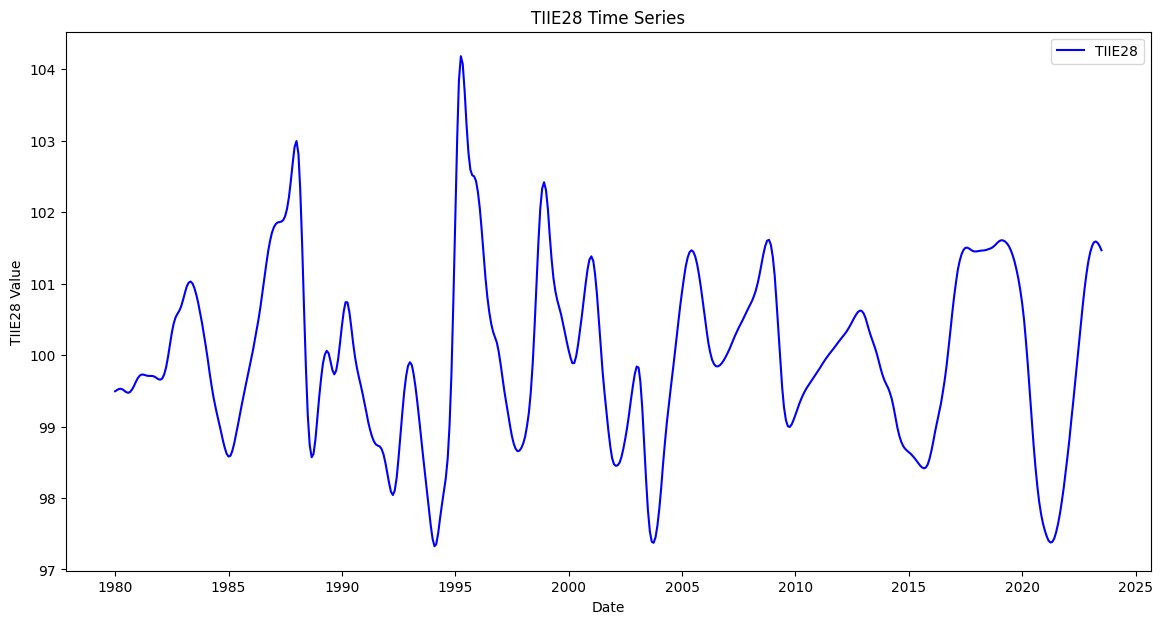

In [9]:
# Graficar la serie temporal de TIIE28
plt.figure(figsize=(14,7))
plt.plot(df.index, df['TIIE28'], label='TIIE28', color='blue')
plt.title('TIIE28 Time Series')
plt.xlabel('Date')
plt.ylabel('TIIE28 Value')
plt.legend()
plt.show()

Antes de ajustar un modelo ARIMA, debemos verificar si la serie temporal es estacionaria, ya que los modelos ARIMA asumen que la serie es estacionaria.

Para ello, podemos usar el test de Dickey-Fuller aumentado. Si la serie no es estacionaria, tendremos que diferenciarla. Vamos a realizar el test de Dickey-Fuller aumentado a continuación. 

Una serie temporal es estacionaria si sus propiedades estadísticas, como la media y la varianza, son constantes a lo largo del tiempo.

In [11]:
# Realizar el test de Dickey-Fuller aumentado
adf_test = adfuller(df['TIIE28'])

# Mostrar los resultados
adf_output = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in adf_test[4].items():
    adf_output['Critical Value (%s)' % key] = value

adf_output

Test Statistic                  -5.366189
p-value                          0.000004
#Lags Used                       8.000000
Number of Observations Used    514.000000
Critical Value (1%)             -3.443136
Critical Value (5%)             -2.867179
Critical Value (10%)            -2.569774
dtype: float64

El resultado del test de Dickey-Fuller aumentado muestra que el estadístico de prueba es menor que el valor crítico al 1%, y el p-valor es significativamente bajo (prácticamente cero). Esto significa que podemos rechazar la hipótesis nula de que la serie tiene una raíz unitaria y considerar que la serie temporal es estacionaria.

Con una serie temporal estacionaria, podemos proceder a determinar los parámetros del modelo ARIMA. Necesitaremos identificar los parámetros p, d y q que corresponden a la autoregresión, la diferenciación y la media móvil del modelo ARIMA, respectivamente.

El siguiente paso será examinar las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF) para ayudarnos a determinar estos parámetros. Vamos a graficar la ACF y PACF. ​

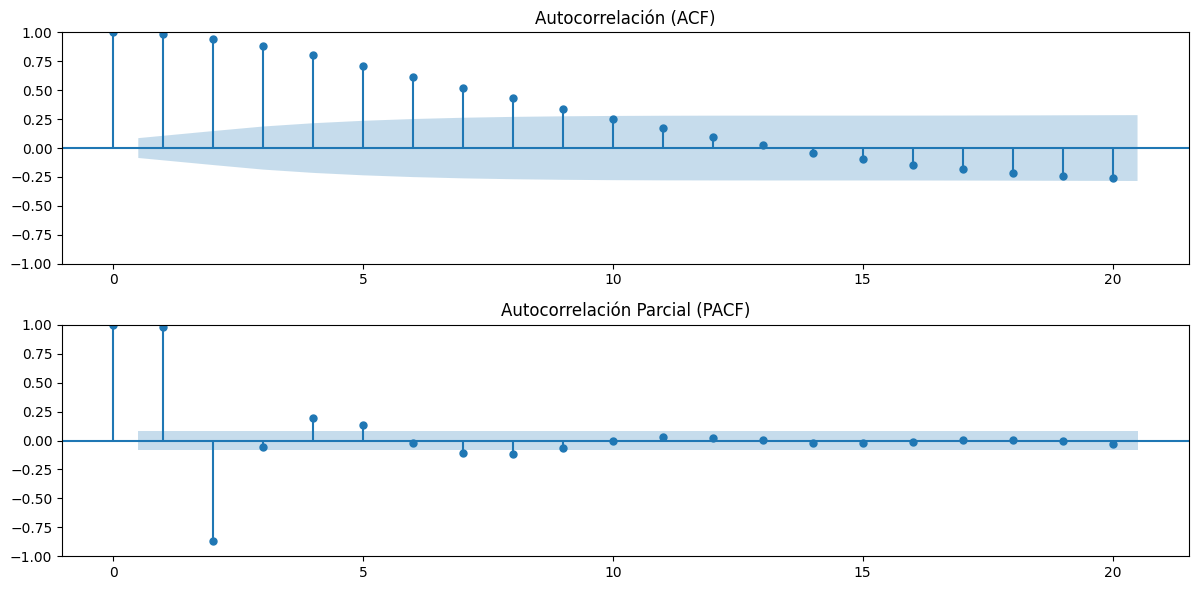

In [13]:
# Gráficas de Autocorrelación (ACF) y Autocorrelación Parcial (PACF)
plt.figure(figsize=(12,6))
plt.subplot(211)
plot_acf(df['TIIE28'], ax=plt.gca(), lags=20)
plt.title('Autocorrelación (ACF)')

plt.subplot(212)
plot_pacf(df['TIIE28'], ax=plt.gca(), lags=20)
plt.title('Autocorrelación Parcial (PACF)')
plt.tight_layout()

plt.show()

En el gráfico ACF, debemos fijarnos en cuántos lags tienen barras significativas (fuera del área sombreada). Esto nos dará una idea de q. En el gráfico PACF, observa de manera similar para determinar p.

In [15]:
# Definir el modelo ARIMA con los parámetros identificados
p = 7
d = 1
q = 10

modelo = ARIMA(df['TIIE28'], order=(p,d,q))

# Ajustar el modelo
resultado = modelo.fit()

# Resumen del modelo
print(resultado.summary())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 TIIE28   No. Observations:                  523
Model:                ARIMA(7, 1, 10)   Log Likelihood                1691.007
Date:                Sun, 26 Nov 2023   AIC                          -3346.014
Time:                        12:49:28   BIC                          -3269.376
Sample:                    01-01-1980   HQIC                         -3315.997
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          3.1636      0.369      8.575      0.000       2.441       3.887
ar.L2         -4.6980      1.071     -4.385      0.000      -6.798      -2.598
ar.L3          4.3750      1.568      2.791      0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


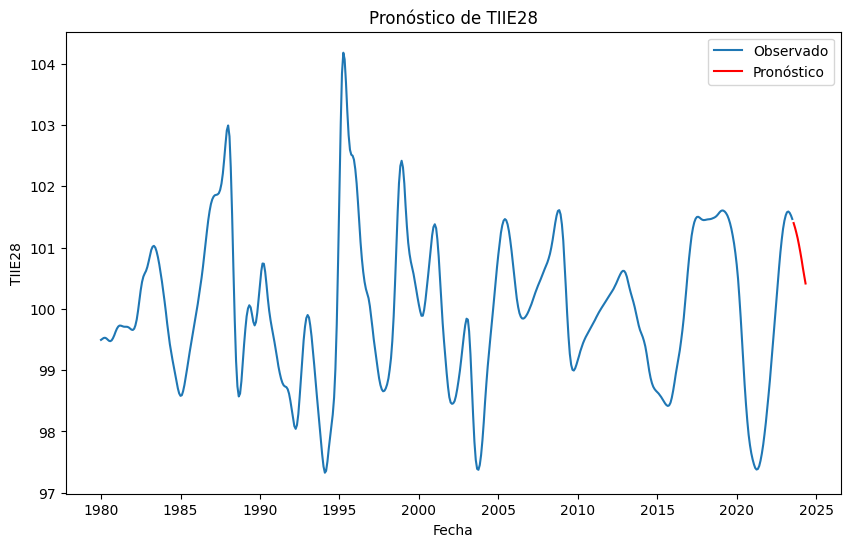

In [20]:
# Pronóstico para los próximos 5 períodos
pronostico = resultado.forecast(steps=10)

# Graficar los resultados
plt.figure(figsize=(10,6))
plt.plot(df['TIIE28'], label='Observado')
plt.plot(pronostico, label='Pronóstico', color='red')
plt.title('Pronóstico de TIIE28')
plt.xlabel('Fecha')
plt.ylabel('TIIE28')
plt.legend()
plt.show()

# Comparativa con autoarima

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6303.245, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1721.693, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-157.484, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-1468.829, Time=0.39 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-2292.364, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-3018.378, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-3247.445, Time=0.11 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-1652.248, Time=0.51 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-3213.484, Time=0.49 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.51 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0] intercept
Total fit time: 2.538 seconds
                               SARIM

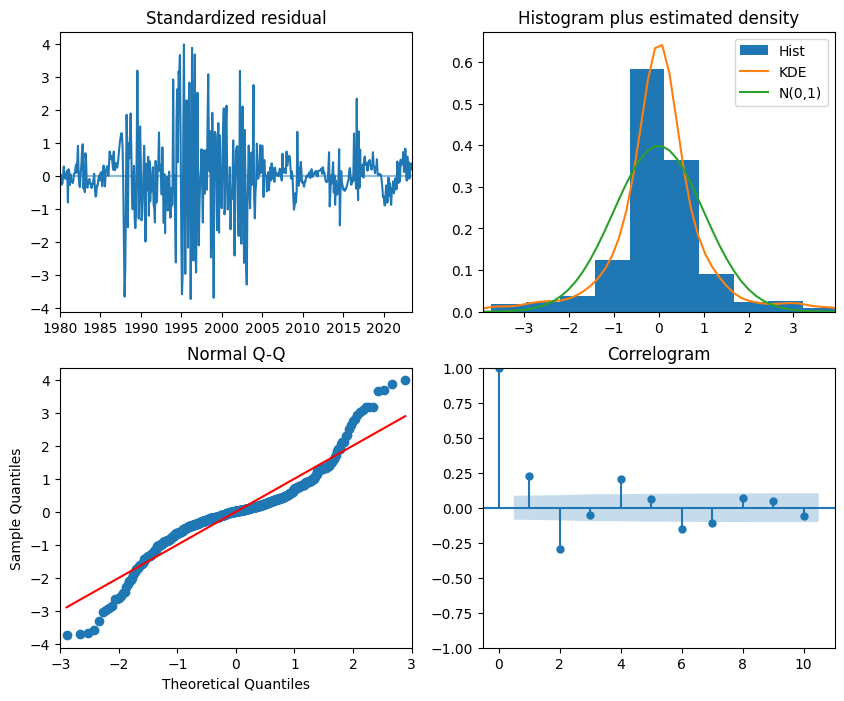

In [19]:
# Ajustar el modelo auto_arima
modelo_auto = auto_arima(df['TIIE28'], 
                         start_p=0, start_q=0,
                         test='adf',       # Utiliza el test 'adf' para encontrar el orden de diferenciación 'd'
                         max_p=5, max_q=5, # Máximo número de términos AR y MA
                         m=1,              # Frecuencia de la serie temporal
                         d=None,           # Dejar que el modelo determine 'd'
                         seasonal=False,   # Sin estacionalidad
                         start_P=0, 
                         D=0, 
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

# Imprimir el resumen del modelo
print(modelo_auto.summary())

# Para el diagnóstico del modelo
modelo_auto.plot_diagnostics(figsize=(10,8))
plt.show()

In [38]:
# Suponiendo que deseas predecir 5 periodos en el futuro
num_periodos = 10

# Realizar predicciones con el modelo auto_arima
pronostico_auto = modelo_auto.predict(n_periods=num_periodos)

# Crear un rango de fechas comenzando desde el día siguiente a la última fecha en tus datos
ultimo_dia = df.index[-1]
primer_dia_del_proximo_mes = ultimo_dia + pd.offsets.MonthBegin(1)
fechas_futuras = pd.date_range(start=primer_dia_del_proximo_mes, periods=num_periodos, freq='MS')

# Crear un DataFrame para las predicciones con auto_arima
pronostico_auto_df = pd.DataFrame(pronostico_auto, index=fechas_futuras, columns=['TIIE28_pronostico_auto'])

In [56]:
# Predicción con el modelo ARIMA(7, 1, 10)
pronostico_original = resultado.forecast(steps=10)

# Convertir a DataFrame
pronostico_original_df = pd.DataFrame(pronostico_original)
pronostico_original_df.rename(columns={'predicted_mean': 'TIIE28_pronostico_auto'}, inplace=True)

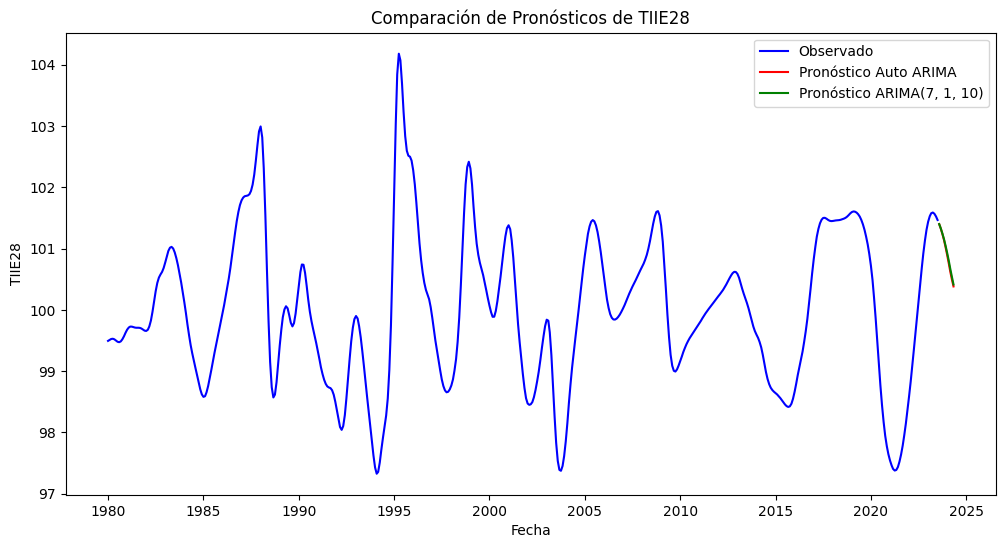

In [58]:
# Graficar los resultados
plt.figure(figsize=(12,6))
plt.plot(df['TIIE28'], label='Observado', color='blue')
plt.plot(pronostico_auto_df, label='Pronóstico Auto ARIMA', color='red')
plt.plot(pronostico_original_df, label='Pronóstico ARIMA(7, 1, 10)', color='green')
plt.title('Comparación de Pronósticos de TIIE28')
plt.xlabel('Fecha')
plt.ylabel('TIIE28')
plt.legend()
plt.show()

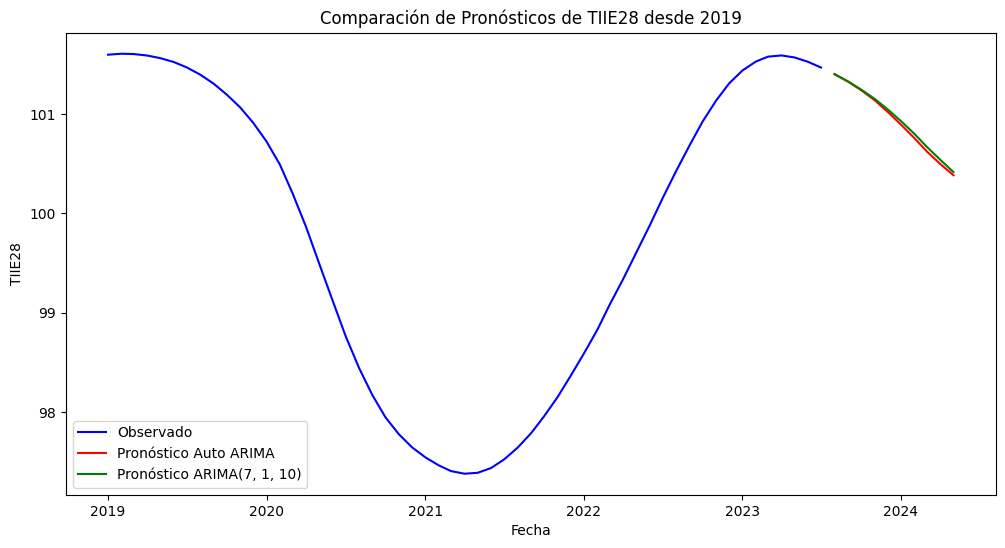

In [61]:
# Filtrar los datos para mostrar solo desde 2019 en adelante
df_filtrado = df[df.index >= '2019-01-01']

# Graficar los resultados
plt.figure(figsize=(12,6))
plt.plot(df_filtrado['TIIE28'], label='Observado', color='blue')
plt.plot(pronostico_auto_df, label='Pronóstico Auto ARIMA', color='red')
plt.plot(pronostico_original_df, label='Pronóstico ARIMA(7, 1, 10)', color='green')
plt.title('Comparación de Pronósticos de TIIE28 desde 2019')
plt.xlabel('Fecha')
plt.ylabel('TIIE28')
plt.legend()
plt.show()